In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_olivetti_faces
from os import listdir
import math

#### Get data

In [108]:
downloaded_data = fetch_olivetti_faces()
# print(downloaded_data['images'].shape)
data = downloaded_data['data']
labels = downloaded_data['target']

In [110]:
data.shape

(400, 4096)

#### Split data to train, test and validation

In [148]:
data_df = pd.DataFrame(data)
data_df['label'] = labels
test_data = data_df.groupby('label', group_keys=False).apply(lambda x: x.sample(frac=0.2)) ## use 0.2 of data for test
test_label = test_data['label']
test_data.drop('label', axis=1, inplace=True)
print('shape of test data: ' + str(test_data.shape))

data_df = data_df.drop(test_data.index)
val_data = data_df.groupby('label', group_keys=False).apply(lambda x: x.sample(frac=0.2)) ## use 0.2 of data for validation
val_label = val_data['label']
val_data.drop('label', axis=1, inplace=True)
print('shape of validation data: ' + str(val_data.shape))

train_data = data_df.drop(val_data.index)
train_label = train_data['label']
train_data.drop('label', axis=1, inplace=True)
print('shape of train data: ' + str(train_data.shape)) ## use 0.2 of data for train

shape of test data: (0, 4096)
shape of validation data: (0, 4096)
shape of train data: (400, 4096)


#### K-means clustering

In [162]:
def plot_elbow(SSE_per_k, title):
    """ This function plot elboe method """
    SSE_per_k = np.array([[k, sse] for k,sse in SSE_per_k.items()])
    plt.plot(SSE_per_k[:,0], SSE_per_k[:,1])
    plt.title(title)
    plt.show()
    
def kmeans_cluster(data, k, centers, tol, max_iter):
    """ this function runs k-means algorithm and returns clusters of any data """
    SSE = 0
    for _ in range(max_iter):
        all_distances = np.zeros((data.shape[0], k))  ## distance of any data to any centers
        for i in range(k):
            dist = np.linalg.norm(data - centers[i], axis=1)
            all_distances[:, i] = dist
        clusters = np.argmin(all_distances, axis=1)  ## find nearest center to any data
        SSE = np.min(all_distances, axis=1).sum()
        converge = True
        for i in range(k):
            new_center = data[clusters==i].mean(axis=0)  ## new centers of clusters
            if np.linalg.norm(new_center - centers[i]) > tol:
                converge = False
            centers[i] = new_center
        if converge:
            break
    return clusters, centers, SSE

#### Run K-means clustering 

In [167]:
SSE_per_k = {}
for k in range(10, 105, 10):
    rand_index = np.random.choice(range(train_data.shape[0]), k, replace=False)
    rand_centers = train_data.iloc[rand_index]
    clusters, centers, SSE = kmeans_cluster(train_data, k, rand_centers.to_numpy(), 0.01, 20)
    SSE_per_k[k] = SSE

#### Plot elbow method

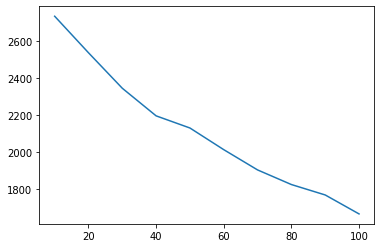

In [163]:
plot_elbow(SSE_per_k, 'elbow method')

#### Show some image of some clusters

In [174]:
def plot_img(data, clusters):
    """ This function gets data and clusters and plot some image of some clusters """
    n_col = 6
    fig, axs = plt.subplots(nrows=10, ncols=n_col, figsize=(20,30))
    cluster_names = list(set(clusters))
    row = 0
    for cluster in cluster_names:
        one_cluster = data.loc[clusters==cluster]
        if one_cluster.shape[0] < n_col:
            continue
        for i in range(n_col):
            img = one_cluster.iloc[i].to_numpy().reshape((64, 64))
            axs[row][i].imshow(img, cmap="gray")
            axs[row][i].title.set_text('img in cluster {}'.format(cluster))
        row += 1
        if row >= 10:
            break
    plt.tight_layout()
    plt.show()

In [176]:
best_k = 40
rand_index = np.random.choice(range(train_data.shape[0]), best_k, replace=False)
rand_centers = train_data.iloc[rand_index]
clusters, centers, SSE = kmeans_cluster(train_data, best_k, rand_centers.to_numpy(), 0.01, 20)

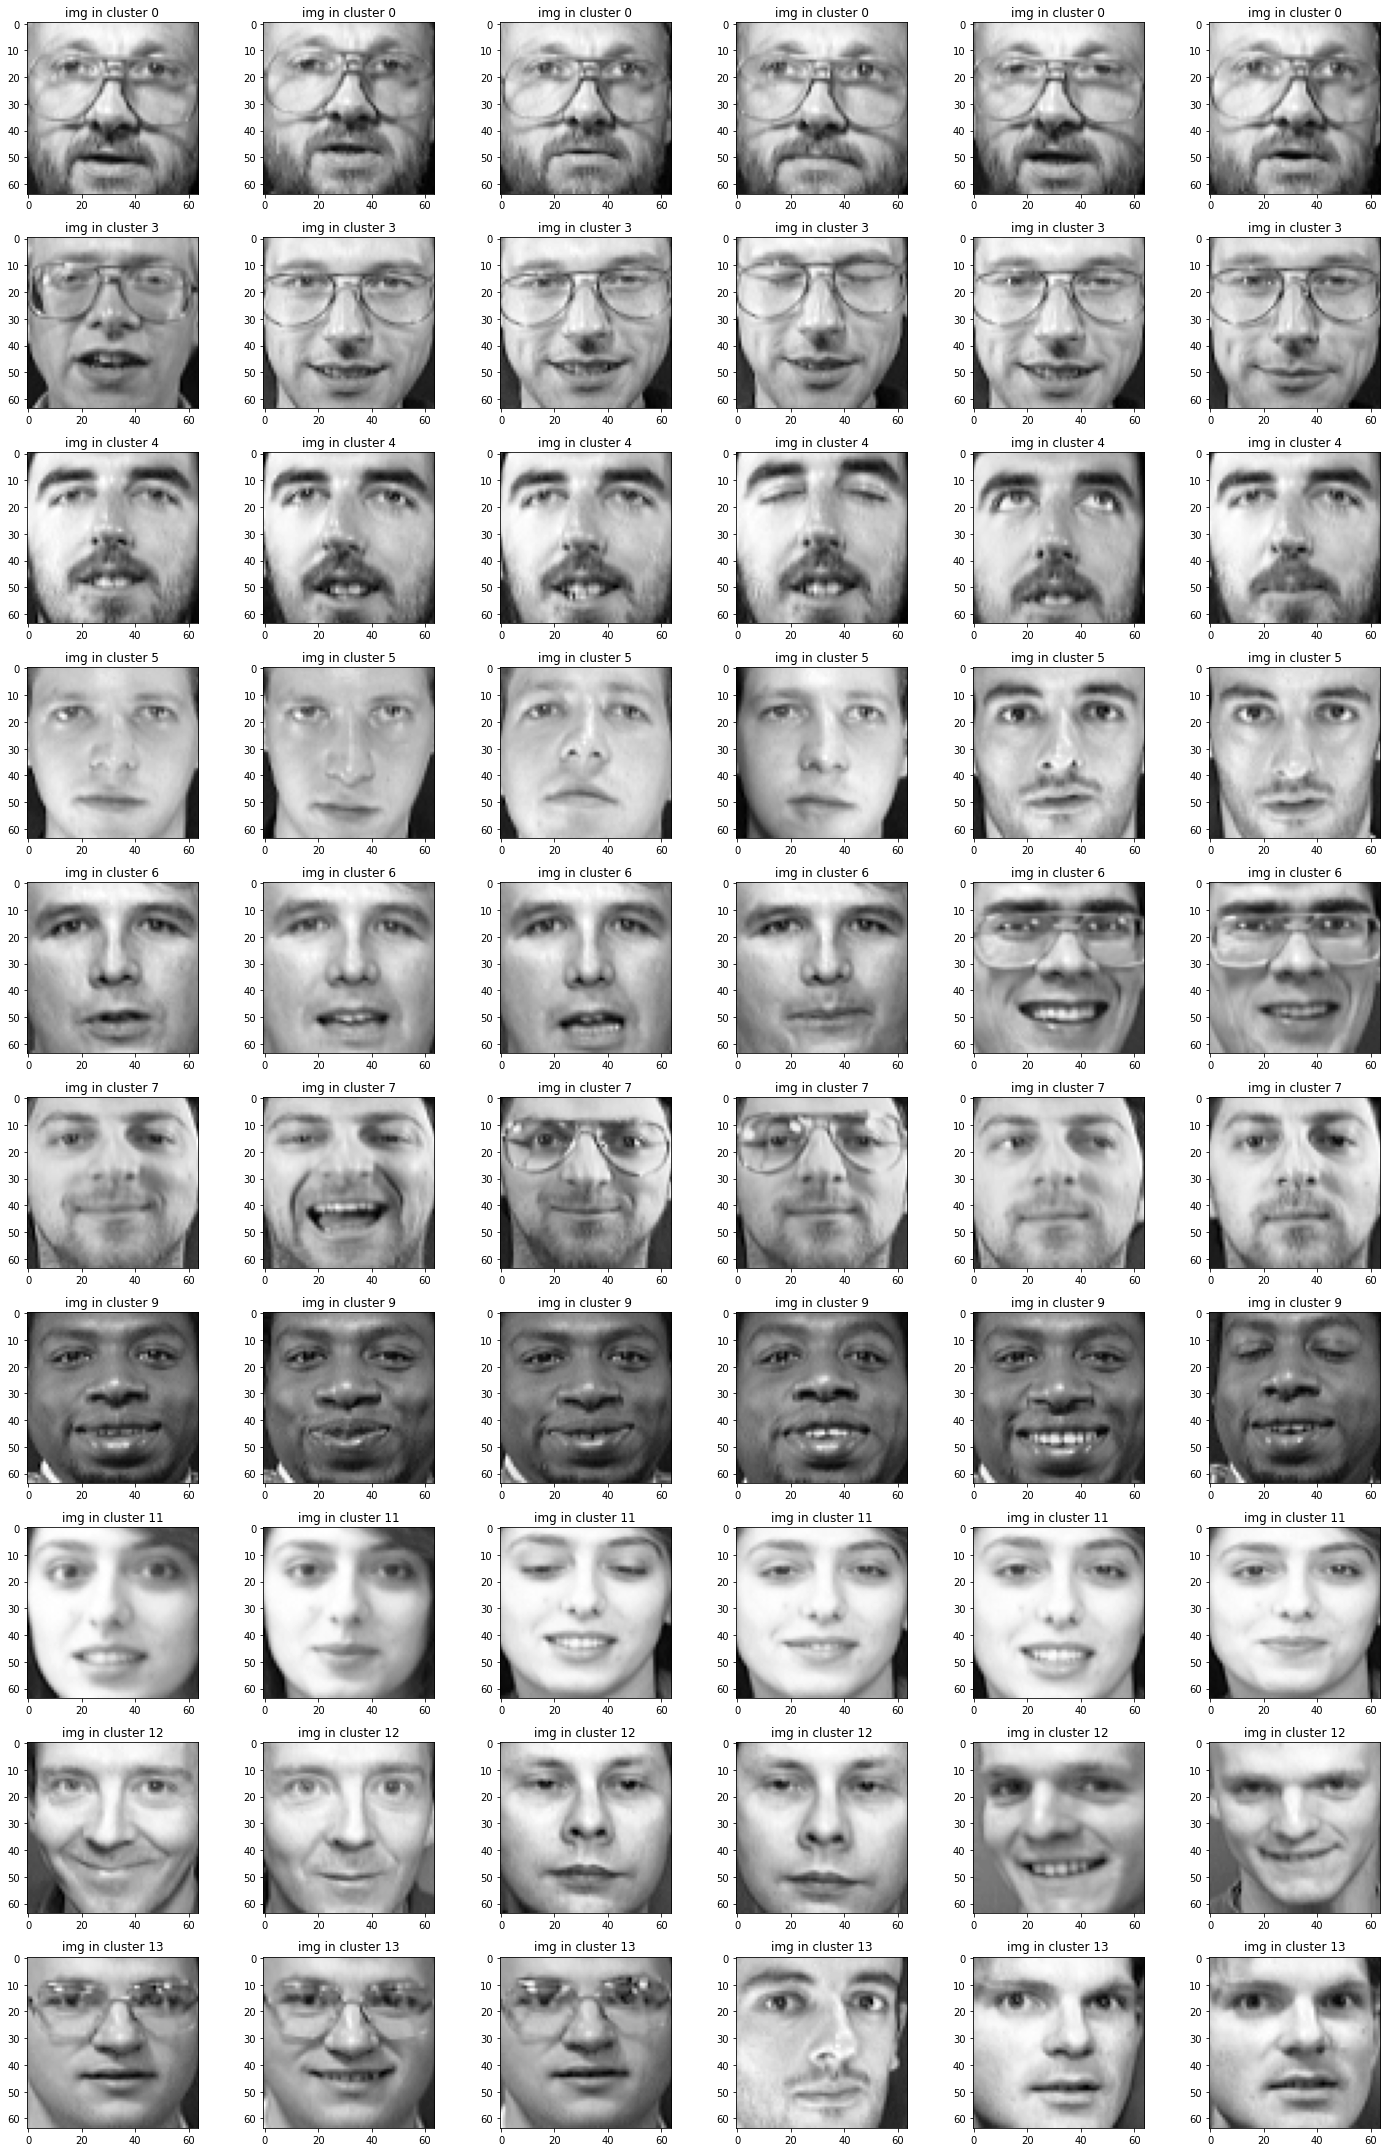

In [177]:
plot_img(train_data, clusters)